# **Grid Search**

Documentation [here](https://github.com/skorch-dev/skorch)

# **0. Set Up**

Before diving in the models, let's reload the notebook to keep it updated.

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Then, let's load the dependencies:

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets

from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from torch.utils.data import DataLoader

# Data science
import spacy
import numpy as np
import time
import random

In [3]:
#Let's not forget to fix the seed for random generated numbers !
SEED = 2020 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Baseline**


# 1. Dataset

### 1.1. NoReC fine

In [4]:
import torchtext
from sentarget.datasets import NoReCfine

TEXT = torchtext.data.Field(lower=False, include_lengths=True, batch_first=True)
LABEL = torchtext.data.Field(batch_first=True, unk_token=None)
FIELDS = [("text", TEXT), ("label", LABEL)]

train_data, eval_data, test_data = NoReCfine.splits(FIELDS)

### 1.2. Vocabulary

In [5]:
from torchtext.vocab import Vectors

VOCAB_SIZE = 1_200_000
VECTORS = Vectors(name='model.txt', url='http://vectors.nlpl.eu/repository/20/58.zip')

# Or use the NoNLPL dataset
# from sentarget.datasets.nonlpl import NoNLPL
# VECTORS = NoNLPL.load()

# Create the vocabulary for words embeddings
TEXT.build_vocab(train_data, eval_data, test_data,
                 max_size = VOCAB_SIZE, 
                 vectors = VECTORS, 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

### 1.3. Iterators

In [6]:
BATCH_SIZE = 64

device = torch.device('cpu')

train_iterator, eval_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, eval_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

# 2. Model

### 2.1. BiLSTM

In [7]:
from sentarget.nn.models.lstm import BiLSTM
from sentarget.nn.models.gru import BiGRU


# Defines the shape of the models
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
EMBEDDINGS = TEXT.vocab.vectors

# 3. Run the grid search with a Tuner class

In [12]:
from sentarget import Tuner


PAD_IDX_TEXT = TEXT.vocab.stoi[TEXT.pad_token]
PAD_IDX_LABEL = LABEL.vocab.stoi[LABEL.pad_token]
UNK_IDX_TEXT = TEXT.vocab.stoi[TEXT.unk_token]

options = {
    # Defaults options
    'verbose': True,
    'saves': True,
    'dirsaves': 'saves_test',
    'compare_on': 'f1_score'
}

# Hyper parameters to tune
params_hyper = {
    # Default parameters
    'epochs':                    [1],
    'batch_size':                [64],
    'lr':                        [0.1],
    'vectors_name':              'model.txt',
    'vectors_url':               'http://vectors.nlpl.eu/repository/20/58.zip',
    'use_pretrained_embeddings': True,
}

# Parameters affecting the model
params_model = {
    'model':         [BiLSTM, BiGRU],
    'input_dim':     [len(TEXT.vocab)],           # Should not be modified
    'embedding_dim': [100],                       # Should not be modified
    'hidden_dim':    [100],      
    'output_dim':    [len(LABEL.vocab)],          # Should not be modified
    'n_layers':      [2],
    'bidirectional': [True],
    'dropout':       [0.2], 
    'pad_idx_text':  [PAD_IDX_TEXT],              # Should not be modified
    'pad_idx_label': [PAD_IDX_LABEL],             # Should not be modified
    'unk_idx_text':  [UNK_IDX_TEXT],              # Should not be modified
    'embeddings':    [EMBEDDINGS]
}                                                 # Should not be modified

# Default parameters that will be used
params_loss = {
    'criterion':    [torch.nn.CrossEntropyLoss],
    'ignore_index': PAD_IDX_LABEL,
    'weight':       [torch.tensor([1, 0.06771941, 0.97660534, 0.97719714, 0.98922782, 0.98925029])]
}
params_optim = {
    'optimizer': [torch.optim.Adam],
}
     
tuner = Tuner(
    params_hyper = params_hyper, 
    params_model = params_model, 
    params_loss  = params_loss,
    params_optim = params_optim,
    options      = options
)

In [15]:
tuner.fit(train_iterator, eval_iterator)

GridSearch(
  (options): Parameters(saves=True, dirsaves='saves_test', compare_on='f1_score', verbose=True)
  (session): Permutations(hyper=1, model=2, loss=1, optim=1, total=2)
)

Search n°1: BiLSTM
Configuration(
  (hyper): Variables(epochs=1, batch_size=64, lr=0.1, vectors_name='model.txt', vectors_url='http://vectors.nlpl.eu/repository/20/58.zip', use_pretrained_embeddings=True)
  (model): Parameters(input_dim=23574, embedding_dim=100, hidden_dim=100, output_dim=6, n_layers=2, bidirectional=True, dropout=0.2, pad_idx_text=1, pad_idx_label=0, unk_idx_text=0)
  (criterion): CrossEntropyLoss(ignore_index=0)
  (optimizer): Adam()
)
BiLSTM(
  (embedding): Embedding(23574, 100, padding_idx=1)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Performances(
  (train): Scores(loss=1.3210, accuracy=0.8926, score=0.8545, precision=0.2027, recall=0.200

In [14]:
tuner.save()

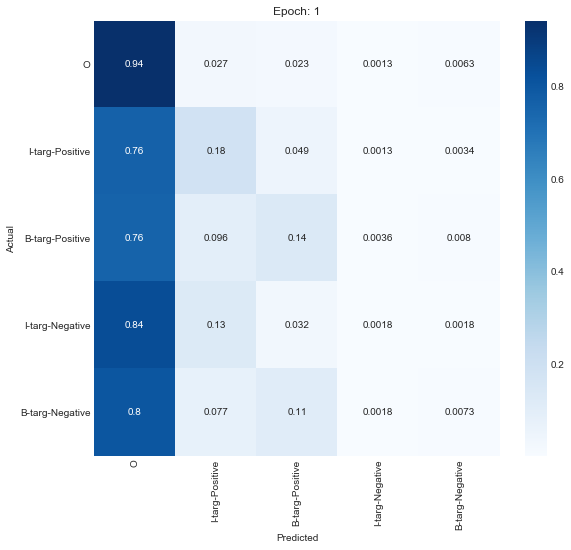

In [16]:
from sentarget.metrics import ConfusionMatrix

fig = plt.figure(figsize=(20, 8))

# confusion matrices for the first model
matrices = tuner.results[0]['performance']['train']['confusion']

N = len(matrices)  # should be equal to EPOCHS
names = LABEL.vocab.itos[1:]  # names of classes, ignore unk and pad

for i, data in enumerate(matrices):
    plt.subplot(N//2 + N%2, 2, i+1)
    confusion = ConfusionMatrix(data=data)
    ax = confusion.plot(names=names, normalize=True, cbar=True)
    plt.title(f"Epoch: {i+1}")
    
plt.show()

# 4. Template for a grid search

## 4.1. Define your grid search and limits

In [17]:
def gridsearch(options={}, params_hyper={}, params_model={}, params_optim={}, params_loss={}):
    """Run the grid search algorithms on the CONLL dataset provided.

    Args:
        options (dict): general options.
        params_hyper (dict): hyper parameters to tune.
        params_model (dict): model's parameters to tune.
        params_optim (dict): optimizer parameters initialization, won't be tuned.
        params_loss (dict): criterion parameters initialization, won't be tuned.

    """

    # 1/ Load the data
    TEXT = data.Field(lower=False, include_lengths=True, batch_first=True)
    LABEL = data.Field(batch_first=True, unk_token=None)
    FIELDS = [("text", TEXT), ("label", LABEL)]
    train_data, eval_data, test_data = NoReCfine.splits(FIELDS)

    # 2/ Build the vocab
    VOCAB_SIZE = 1_200_000
    VECTORS_NAME = params_hyper['vectors_name']
    VECTORS_URL = params_hyper['vectors_url']
    VECTORS = Vectors(name=VECTORS_NAME, url=VECTORS_URL)
    TEXT.build_vocab(train_data, test_data, eval_data,
                     max_size=VOCAB_SIZE,
                     vectors=VECTORS,
                     unk_init=torch.Tensor.normal_)
    LABEL.build_vocab(train_data)

    # 3/ Load iterators
    BATCH_SIZE = params_hyper['batch_size']
    device = torch.device('cpu')
    train_iterator, eval_iterator, test_iterator = data.BucketIterator.splits((train_data, eval_data, test_data),
                                                                              batch_size=BATCH_SIZE,
                                                                              sort_within_batch=True,
                                                                              device=device)
    
    # Initialize the embedding layer
    if params_hyper['use_pretrained_embeddings']:
        params_model['embeddings'] = TEXT.vocab.vectors
    
    # 4/ Grid Search
    tuner = Tuner(
        params_hyper = params_hyper,
        params_model = params_model,
        params_loss  = params_loss,
        params_optim = params_optim,
        options      = options
    )

    # Search
    tuner.fit(train_iterator, eval_iterator)
    tuner.save(dirsaves=options['dirsaves'])

## 4.2. Load parameters from a configuration file

In [18]:
import numpy
import torch
import sentarget
import configparser


config = configparser.ConfigParser()
config.read('gridsearch.ini')

options = {key: eval(value) for (key, value) in dict(config.items('Options')).items()}
params_hyper = {key: eval(value) for (key, value) in dict(config.items('Hyper')).items()}
params_model = {key: eval(value) for (key, value) in dict(config.items('Model')).items()}
params_loss = {key: eval(value) for (key, value) in dict(config.items('Criterion')).items()}
params_optim = {key: eval(value) for (key, value) in dict(config.items('Optimizer')).items()}

## 4.3. Or do it manually

In [19]:
from sentarget import Tuner
from torchtext import data


# General options
options = {
    # Defaults options
    'verbose': True,
    'saves': True,
    'dirsaves': 'saves_test2',
}

# Hyper parameters to tune
params_hyper = {
    # Default parameters
    'epochs':                    [1],
    'batch_size':                [64],
    'lr':                        [0.01],
    'vectors_name':              'model.txt',
    'vectors_url':               'http://vectors.nlpl.eu/repository/20/58.zip',
    'use_pretrained_embeddings': True,
}

# Parameters affecting the models
params_model = {
    'model':         [sentarget.nn.models.lstm.BiLSTM, sentarget.nn.models.gru.BiGRU],
    'input_dim':     [len(TEXT.vocab)],           # Should not be modified
    'embedding_dim': [100],                       # Should not be modified
    'hidden_dim':    [100],      
    'output_dim':    [len(LABEL.vocab)],          # Should not be modified
    'n_layers':      [2],
    'bidirectional': [True],
    'dropout':       [0.2], 
    'pad_idx_text':  [PAD_IDX_TEXT],              # Should not be modified
    'pad_idx_label': [PAD_IDX_LABEL],             # Should not be modified
    'unk_idx_text':  [UNK_IDX_TEXT],              # Should not be modified
    'embeddings':    [EMBEDDINGS]                 # Should not be modified
}

# Default parameters that will be used
params_loss = {
    'criterion':    [torch.nn.CrossEntropyLoss],
    'ignore_index': PAD_IDX_LABEL,
    'weight':       [torch.tensor([1, 0.06771941, 0.97660534, 0.97719714, 0.98922782, 0.98925029])]
}
params_optim = {
    'optimizer': [torch.optim.Adam],
}

# 5. Run the grid search

In [20]:
gridsearch(
    params_hyper = params_hyper, 
    params_model = params_model, 
    params_loss  = params_loss, 
    params_optim = params_optim,
    options      = options
)

GridSearch(
  (options): Parameters(saves=True, dirsaves='saves_test2', compare_on='accuracy', verbose=True)
  (session): Permutations(hyper=1, model=2, loss=1, optim=1, total=2)
)

Search n°1: BiLSTM
Configuration(
  (hyper): Variables(epochs=1, batch_size=64, lr=0.01, vectors_name='model.txt', vectors_url='http://vectors.nlpl.eu/repository/20/58.zip', use_pretrained_embeddings=True)
  (model): Parameters(input_dim=23574, embedding_dim=100, hidden_dim=100, output_dim=6, n_layers=2, bidirectional=True, dropout=0.2, pad_idx_text=1, pad_idx_label=0, unk_idx_text=0)
  (criterion): CrossEntropyLoss(ignore_index=0)
  (optimizer): Adam()
)
BiLSTM(
  (embedding): Embedding(23574, 100, padding_idx=1)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=200, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Performances(
  (train): Scores(loss=0.5174, accuracy=0.9174, score=0.8945, precision=0.1559, recall=0.1

# Analysis

In [ ]:
import json

with open('saves_test/gridsearch.json') as f:
    results = json.load(f)

In [ ]:
# First model...
plt.plot(results["results"][0]["performance"]["train"]["accuracy"])
# Second...
plt.plot(results["results"][1]["performance"]["train"]["accuracy"])